In [480]:
# importing pandas
import pandas as pd
# importing geopandas
import geopandas as gpd
# importing datetime
import datetime
# importing numpy
import numpy as np
# importing matplotlib
import matplotlib.pyplot as plt
# importing seaborn
import seaborn as sns

### MASS SHOOTING (data cleaning)

In [481]:
# importing mass shooting data, finding shape
df = pd.read_csv('massshootingdata.csv')

In [482]:
# suspects column with the number of suspects
df["suspects"]= (df["# Subjects-Suspects Injured"] 
                 + df["# Subjects-Suspects Killed"] 
                 + df["# Subjects-Suspects Arrested"])
# boolean column showing if a suspect was killed
df["suspectkilled"] = df["# Subjects-Suspects Killed"].map(lambda a : a > 0)

# dropping unnecessary columns
df = df.drop(["# Subjects-Suspects Injured", "# Subjects-Suspects Killed", 
              "# Subjects-Suspects Arrested", "Operations", "Address"], axis=1)


In [483]:
# renaming columns to clarify purpose & simplify the coding process
rename_dict = {
    "Incident ID": "id",
    "Incident Date": "date",
    "State": "state",
    "City Or County": "area",
    "# Victims Injured": "injuries",
    "# Victims Killed": "fatalities",
}
df.rename(columns=rename_dict, inplace=True)

In [484]:
df["tot_victims"] = df["injuries"] + df["fatalities"]

In [485]:
month_num = {
    "January": 1,
    "February": 2,
    "March": 3,
    "April": 4,
    "May": 5,
    "June": 6,
    "July": 7,
    "August": 8,
    "September": 9,
    "October": 10,
    "November": 11,
    "December": 12
}

# df["year"] = df.date.map(lambda a: int(a[-4:]))

def string_to_date(row):
    parts = row.date.split(" ")
    month = month_num[parts[0]]
    day = int(parts[1].rstrip(','))
    year = int(parts[2])
    row["date"] = datetime.date(year, month, day)
    row["year"] = year
    return row
    
df = df.apply(string_to_date, axis=1)

In [486]:
df = (df.loc[(df.year >= 2021) & (df.year <= 2022)]
      .reset_index()
      .drop("index", axis=1))

### GUN LAWS (data cleaning)

In [487]:
gun_laws_df = pd.read_csv("gunlaws.csv")

In [488]:
gun_laws_df = gun_laws_df.loc[gun_laws_df.year == 2020].drop("year", axis=1)

In [489]:
# gun_laws_df.columns.values

In [490]:
gun_laws_df = gun_laws_df.set_index("state").sort_values(by='state')

In [491]:
gun_laws_df.tail()

,felony,invcommitment,invoutpatient,danger,drugmisdemeanor,alctreatment,alcoholism,relinquishment,violent,violenth,...,expartedating,dvrosurrender,dvrosurrendernoconditions,dvrosurrenderdating,expartesurrender,expartesurrendernoconditions,expartesurrenderdating,dvroremoval,stalking,lawtotal
state,,,,,,,,,,,,,,,,,,,,,
Virginia,1,1,1,1,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,25
Washington,1,1,1,1,0,0,0,0,0,0,...,1,1,0,1,1,0,1,0,0,55
West Virginia,1,1,1,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,18
Wisconsin,1,1,1,1,0,1,0,0,0,0,...,0,1,1,1,0,0,0,0,1,23
Wyoming,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7


In [492]:
columns = []
for column in gun_laws_df:
    col_sum = gun_laws_df[column].sum()
    if col_sum >= 17:
        columns.append(column)

In [493]:
gun_laws_df = gun_laws_df.loc[:, columns]
gun_laws_df.shape

(50, 30)

In [494]:
gun_total_S = gun_laws_df.loc[:, "lawtotal"]

### SHAPEFILES (data cleaning)

In [495]:
shape_df = gpd.read_file("shapefiles/states.shp")

In [496]:
territories = ["American Samoa", "Commonwealth of the Northern Mariana Islands", 
               "Puerto Rico", "United States Virgin Islands",
               "District of Columbia", "Guam"]
shape_df = (shape_df
            .loc[:, ["NAME", "STUSPS", "geometry"]]
            .rename(columns={"NAME": "state", "STUSPS": "abbreviation"})
            .set_index("state")
            .drop(territories, axis=0)
            .sort_values(by='state'))

### POPULATION (data cleaning)

In [497]:
pop_df = pd.read_csv('populationdata.csv')

In [498]:
pop_df = (pop_df
            .loc[:, ["NAME", "POPESTIMATE2019"]]
            .rename(columns={"NAME": "state", "POPESTIMATE2019": "population"})
            .set_index("state"))

### BRINGING IT ALL TOGETHER!

In [520]:
states_df = shape_df.join(pop_df)

In [500]:
# combo_df = (pd.merge(df, states_df, on="state")
            .sort_values(by="date", ascending=False)
            .reset_index()
            .drop("index", axis=1))

In [501]:
# states_df_large = shape_df.join(pop_df.join(gun_laws_df))

In [502]:
# combo_df_large = (pd.merge(df, states_df_large, on="state")
                 .sort_values(by="date", ascending=False)
                 .reset_index()
                 .drop("index", axis=1))

In [503]:
# combo_df

,id,date,state,area,injuries,fatalities,suspects,suspectkilled,tot_victims,year,abbreviation,geometry,population,lawtotal
0,2492253,2022-12-31,Alabama,Mobile,7,1,2,False,8,2022,AL,"POLYGON ((-9841333.855 3579579.495, -9841349.6...",4903185,10.0
1,2491656,2022-12-31,Arizona,Phoenix,9,0,0,False,9,2022,AZ,"POLYGON ((-12761162.105 4147165.875, -12761214...",7278717,8.0
2,2490925,2022-12-30,Texas,Humble,3,2,0,False,5,2022,TX,"POLYGON ((-11473106.144 3889876.760, -11473097...",28995881,18.0
3,2491054,2022-12-30,Tennessee,Memphis,3,1,0,False,4,2022,TN,"POLYGON ((-9945959.215 4370089.033, -9944979.2...",6829174,22.0
4,2489614,2022-12-28,New York,Bronx,3,1,2,False,4,2022,NY,"MULTIPOLYGON (((-8866092.533 5160809.769, -886...",19453561,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,1893754,2021-01-03,Florida,Miami,6,0,0,False,6,2021,FL,"MULTIPOLYGON (((-9734892.689 3569910.909, -973...",21477737,30.0
1307,1892114,2021-01-01,Iowa,Sioux City,4,1,3,False,5,2021,IA,"POLYGON ((-10312404.419 4952179.681, -10312552...",3155070,24.0
1308,1892704,2021-01-01,Texas,Amarillo,3,1,1,False,4,2021,TX,"POLYGON ((-11473106.144 3889876.760, -11473097...",28995881,18.0
1309,1892034,2021-01-01,Arkansas,Fort Smith,6,0,2,False,6,2021,AR,"POLYGON ((-10515267.713 4101325.818, -10515269...",3017804,11.0


In [515]:
tot_victims = df.groupby("state").tot_victims.sum()

In [537]:
victims_df = pd.merge(tot_victims, gun_laws_df, on="state")
combo_df = pd.merge(victims_df, states_df, on="state")

In [540]:
# victims per capita
combo_df["vpc"] = combo_df.tot_victims / combo_df.population
data_df = combo_df.drop(["tot_victims", "abbreviation", "lawtotal", "geometry", "population"], axis=1)

In [542]:
data_df.head()

,felony,invcommitment,danger,recordsdealerh,age21handgunsale,age18longgunsale,universalpermith,backgroundpurge,statechecksh,gvrolawenforcement,...,cap14,immunity,mcdv,mcdvdating,dvro,dvrodating,dvrosurrender,dvrosurrendernoconditions,stalking,vpc
state,,,,,,,,,,,,,,,,,,,,,
Alabama,0,1,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0.000037
Alaska,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000007
Arizona,1,1,1,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0.000015
Arkansas,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000023
California,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0.000012


<AxesSubplot:>

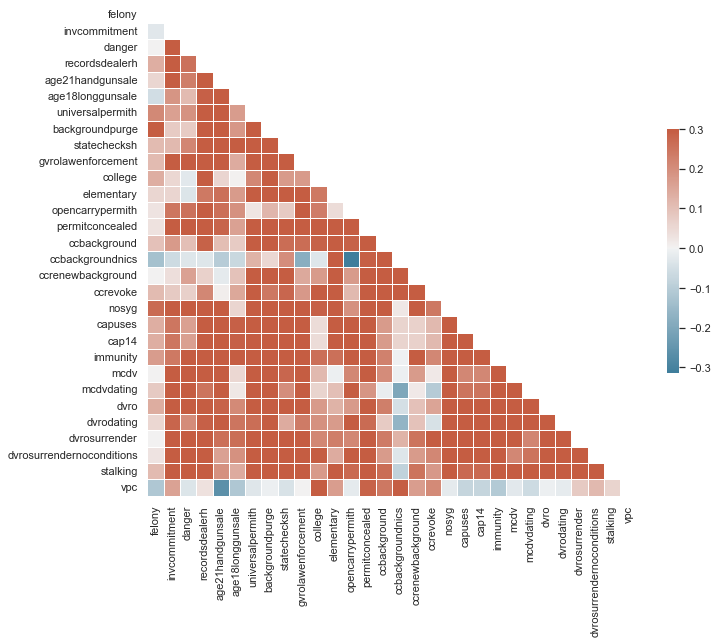

In [543]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = data_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})